# One GiGANtic Leap...

> Creating artifial life. Or at least removing batch effects from scRNA ensembles.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]


# Introduction

Generative Adversarial Networks are more than a novel deep learning architecture. They are powerful game-theoretic constructs with potential to change much of our understanding of what is "real". If what is real is useful insofar as what we perceive is useful, then we may be in touble. The advent of GANs in the early part of this century has distrupted the way reality is made. Deep networks are becoming immensely powerful at learning class-posterior distributions $P(Y|X=x)$. However, generative models are doing something much trickier: learning $P(X,Y)$. GANs use a discriminator of $P(Y|X)$ to accomplish this. Thus, adversarial nets are a balancing act to implement and train, but provide unparalleled results. On the one hand, this could seriousy destroy media (Microsoft's MSN recently replaced human authors with generative machines), social stability, and our politics (think DeepFakes). However, there is reason to be hopeful.

One realm I'm particularly excited to see GANs making an entrance is in the biosciences. GANs (and really any high-fidelity generative model) may hold the promise to generate sythetic datasets to build better supervised learners on features such as genomes, proteomes, and bioimages. This could help bring machine learning closer to solving few-shot and zero-shot problems in medicine.

Another example is for the purposes of simulation and modeling. Tons of assumptions must be made during modeling (for, say, a pandemic) that may not prove realistic. On the other hand, epidemiological datasets may be limited in scope and depth, such that sparse or missing features from a data collection stage could prove vital if not for their low frequencies. Simulating patient risk pools for disease-fighting or drug design via a GAN is one potential method to overcome this, as we can sample from $P(Y,X=x_{minority})$ via a model trained to discriminate perfectly on $P(Y|X)$.

Bioengineering is another intriguing space, whereby *in-silico* experimentation meets the lab bench through simulating data like yeast genomes. There's even the potential to build a *life factory* through generating realistic but novel oligomers and augmenting existing genomes (possible given how splicing is currently solved).

In any event, we should know just how to 1) Train a GAN, and 2) Use it to augment an existing workflow. In this post, I will begin by using the COVID-19 cell atlas as a source of features, and $X$ will be the single-cell read counts. That is, single-cell profiling of COVID-19 patients will provide the raw data to build a generative adversarial network. We will begin by training a discriminator $f$ to learn a classification $f(X) = y$, or $P(Y|X)$. Then, the generative model will begin to simulate $X,y$ pairs, and be trained to accurately generate $P(X,Y)$.

This can be and is used to generate realistic data, or samples on $P(X|Y=y)$ (such as realistic read-counts of single-cell data given patient phenotypes). We can use this trained generative model to shore up minority classes to improve classifier performance (another $f(X) = y$, though on held-out test data), or simply to provide *more* data distributed in the same fashion as $X,y$. I will simply generate realistic fake data for now.

# Data

I will use `scanpy` to load in a toy PBMC (peripheral blood mononuclear cell) dataset into a PyTorch `Dataset` object. Features will be normalized single-cell read counts, a correlate of gene expression. Labels will be cell types identified from Louvain clusters.

In [124]:
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
import scanpy as sc

data = sc.datasets.pbmc3k_processed()
train, val = sklearn.model_selection.train_test_split(data,test_size=.25)

le = LabelEncoder().fit(train.obs.louvain)
train.y=le.transform(train.obs.louvain)
val.y=le.transform(val.obs.louvain)

In [125]:
from torch.utils.data import Dataset,DataLoader
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl

class ToySingleCellDataset(Dataset):

    def __init__(self,anndata):
        self.anndata = anndata
        self.X = self.anndata.X
        self.y = self.anndata.y
        self.setup_run = False

    def __len__(self):
        return len(self.anndata)

    def __getitem__(self,idx):
        assert self.setup_run==True, 'Run .setup()'
        return self.X[idx], self.y[idx]

    def setup(self):
        self.X = torch.FloatTensor(self.X)
        self.y = torch.LongTensor(self.y)
        print(f'Data loaded. X is of shape {self.X.shape}, with y of shape {self.y.shape}')
        self.setup_run=True

    def plot_umap(self):
        mpl.rcParams['figure.dpi']= 150
        plt.style.use('dark_background')
        plt.scatter(self.anndata.obsm['X_umap'][:,0],self.anndata.obsm['X_umap'][:,1], c=self.y, alpha=0.20, cmap = 'Pastel1',s=20)
        plt.xlabel('Compenent 1')
        plt.ylabel('Compenent 2')
        plt.title('UMAP, Colored by Cell Type')


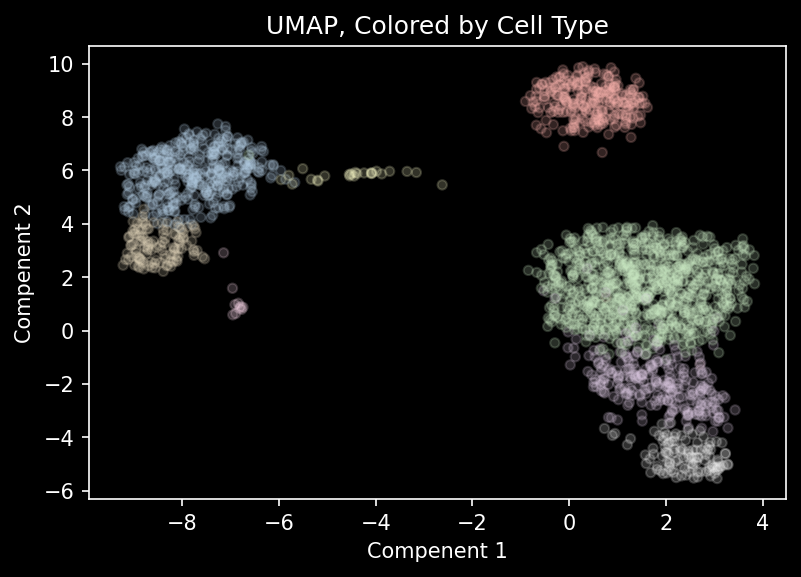

In [126]:
train_dataset, val_dataset = ToySingleCellDataset(train), ToySingleCellDataset(val)
train_dataset.plot_umap()

# Model Architecture

## Probabilistic Intuition

A symmetric view:

i) A generator (in the data-faker view) samples from $P(X|Y=y)$, the distribution of the feature over each class or label.

- Note that $P(X,Y) = P(X|Y)P(Y) \implies P(X|Y) = P(X,Y)/P(Y)$

ii) A discriminator samples on $P(Y|X=x)$, the distribution of the labels over each feature.

- Note that $P(X,Y) = P(Y|X)P(X) \implies P(Y|X) = P(X,Y)/P(X)$


This is because we are provided many instances of $x,y$, where the label space is finite.

Assuming the labels are discrete (i.e., in the case of a classifier and not a regressor), we can always sum to marginalize out the labels from the joint distribution to produce the feature prior $P(x) = \sum_y P(X,Y=y)$.

Likewise, for a continuous feature $X$, we can always integrate to marginalize out the features and produce the class prior $P(y) = \int_x P(Y,X=x)$.

Then, either the "generator" $P(X|Y)$ or the "discriminator" $P(Y|X)$ can be derived by the definition of conditional probability and Bayes' rule (see the above bullets).

## Implementation

We integrate this construction by using a GAN. Classically, this implies that we train a discriminator $f(X) = y$ on $\vec{x},\vec{y}$ and subsequently use this 
    




## The Generative Adversarial Network in PyTorch

In [127]:
import os
from argparse import ArgumentParser
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import pytorch_lightning as pl

In [128]:
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
import scanpy as sc

data = sc.datasets.pbmc3k_processed()
train, val = sklearn.model_selection.train_test_split(data,test_size=.25)

le = LabelEncoder().fit(train.obs.louvain)
train.y_encoded=le.transform(train.obs.louvain)
val.y_encoded=le.transform(val.obs.louvain)

class SingleCellDataModule(pl.LightningDataModule):


    def __init__(self, data_dir: str = './data', batch_size: int = 64, num_workers: int = 8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (1, 28, 28)
        # self.num_classes = 10


    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders. No test stage in our case.
        data = sc.datasets.pbmc3k_processed()
        train, val = sklearn.model_selection.train_test_split(data,test_size=.25)
        le = LabelEncoder().fit(train.obs.louvain)
        train.y=le.transform(train.obs.louvain)
        val.y=le.transform(val.obs.louvain)

        self.train_dataset, self.val_dataset = ToySingleCellDataset(train), ToySingleCellDataset(val)
        self.train_dataset.setup()
        self.val_dataset.setup()
        self.num_classes = len(self.train_dataset.y.unique())


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [129]:
dm = SingleCellDataModule
dm.setup(dm)

Data loaded. X is of shape torch.Size([1978, 1838]), with y of shape torch.Size([1978])
Data loaded. X is of shape torch.Size([660, 1838]), with y of shape torch.Size([660])


In [130]:
next(iter(dm.train_dataset))[0].detach().numpy().shape

(1838,)

In [131]:
class Generator(nn.Module):
    def __init__(self, latent_dim, sc_instance_shape):
        super().__init__()
        self.sc_instance_shape = sc_instance_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(sc_instance_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        sc_instance = self.model(z)
        sc_instance = sc_instance.view(sc_instance.size(0), *self.sc_instance_shape)
        return sc_instance

In [132]:
class Discriminator(nn.Module):
    def __init__(self, sc_instance_shape):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(sc_instance_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, sc_instance):
        sc_instance_flat = sc_instance.view(sc_instance.size(0), -1)
        validity = self.model(sc_instance_flat)

        return validity

In [133]:
 class SingleCellGAN(pl.LightningModule):

    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 100,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = 64,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        data_shape = (1838,)

        self.generator = Generator(latent_dim=self.hparams.latent_dim, sc_instance_shape=data_shape)
        self.discriminator = Discriminator(sc_instance_shape=data_shape)

        self.validation_z = torch.randn(8, self.hparams.latent_dim)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        sc_instances, _ = batch

        # sample noise
        z = torch.randn(sc_instances.shape[0], self.hparams.latent_dim)
        z = z.type_as(sc_instances)

        # train generator
        if optimizer_idx == 0:

            # generate images
            self.generated_sc_instances = self(z)

            # log sampled images
            sample_instances = self.generated_sc_instances[:6]
            grid = torchvision.utils.make_grid(sample_sc_instances)
            self.logger.experiment.add_image('generated_images', grid, 0)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(sc_instances.size(0), 1)
            valid = valid.type_as(sc_instances)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(sc_instances.size(0), 1)
            valid = valid.type_as(sc_instances)

            real_loss = self.adversarial_loss(self.discriminator(sc_instances), valid)

            # how well can it label as fake?
            fake = torch.zeros(sc_instances.size(0), 1)
            fake = fake.type_as(sc_instances)

            fake_loss = self.adversarial_loss(
                self.discriminator(self(z).detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)

        # log sampled images
        sample_sc_instances = self(z)
        grid = torchvision.utils.make_grid(sample_sc_instances)
        self.logger.experiment.add_image('generated_sc_instances', grid, self.current_epoch)

In [119]:
dm = SingleCellDataModule()
model = SingleCellGAN(*dm.size())
trainer = pl.Trainer(gpus=0, max_epochs=5, progress_bar_refresh_rate=20, fast_dev_run=True)
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name          | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------------
0 | generator     | Generator     | 2.6 M  | [2, 100] | [2, 1838]
1 | discriminator | Discriminator | 1.1 M  | ?        | ?        
-----------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
Data loaded. X is of shape torch.Size([1978, 1838]), with y of shape torch.Size([1978])
Data loaded. X is of shape torch.Size([660, 1838]), with y of shape torch.Size([660])


AttributeError: 'ToySingleCellDataset' object has no attribute 'data'

# The Test Case: Data Augmentation for Predicting Clinical Phenotypes

## Hypothesis: Oversampling Features from Minority Cell-Type Membership 